In [33]:
import sympy as sm
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

# models
from modelproject import Solow

import ipywidgets as widgets
from ipywidgets import Output, SelectionSlider
from IPython.display import display, clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We define the solow model with human capital from the listed equations, following standard notation.

$$
\begin{align}
    Y_t & = K_t^{\alpha} H_t^{\phi} (A_tL_t)^{1-\alpha-\phi}, &0<α,φ<1\\
    S_t & = (s_k + s_H) Y_t, &s_k + s_H < 1 \\
    C_t &= Y_t-S_t = (1-s_K-s_H)Y_t \\
    K_{t+1} &= s_K Y_t + (1-\delta)K_t \\
    H_{t+1} &= s_H Y_T + (1-\delta)H_t \\
    L_{t+1} &= (1+n) L_t \\
    A_{t+1} &= (1+g) L_t.
\end{align}
$$

We define the tilde transformation of $X_t$ as
$$
\begin{aligned}
    \tilde{X}_t & \equiv X_t/(A_tL_t) \\
\end{aligned}
$$

Using this transformation, we can rewrite the transitions equation for fysical capital (4) and human capital (5), as

$$
\begin{aligned}

    \tilde{k}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^{\alpha} \tilde{h}_t^{\phi} + (1-\delta) \tilde{k}_t),\\
    
    \tilde{h}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_H \tilde{h}_t^{\alpha} \tilde{h}_t^{\phi} + (1-\delta) \tilde{h}_t).\\

\end{aligned}
$$

We derive the nullclines using sympy

In [11]:
# a. define symbols 
k_tilde, h_tilde = sm.symbols('ktilde_t, htilde_t')
sK, sH = sm.symbols('s_K, s_H')
g, n  = sm.symbols('g, n')
delta, alpha, phi = sm.symbols('delta, alpha, phi')

# b. define transistion equations
trans_k = sm.Eq(k_tilde, 
                1/((1+n)*(1+g))*(sK*k_tilde**alpha*h_tilde**phi+(1-delta)*k_tilde))
trans_h = sm.Eq(h_tilde, 
                1/((1+n)*(1+g))*(sH*k_tilde**alpha*h_tilde**phi+(1-delta)*h_tilde))

# c. derive nullclines from transition equations, isolate for h tilde 
# i. for no change in k tilde
no_change_k = sm.solve(trans_k,h_tilde)[0] 
null_k = sm.Eq(h_tilde, no_change_k)

# ii. for no change in h tilde
no_change_h = sm.solve(trans_h,h_tilde)[0]
null_h = sm.Eq(h_tilde, no_change_h)

# d. display nullclines 
print('no change in k tilde:')
display(null_k)
print('no change in h tilde:')
display(null_h)


no change in k tilde:


Eq(htilde_t, (ktilde_t**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/phi))

no change in h tilde:


Eq(htilde_t, ((delta + g*n + g + n)/(ktilde_t**alpha*s_H))**(1/(phi - 1)))

As we can see from the power of $\tilde{k}_t$, the nullcline for $\Delta \tilde{k}_t = 0$ and $\Delta \tilde{h}_t = 0$ is respectively convex and concave in the $\tilde{k}_t$-th dimension. We can explicitly show this by inserting values in the functions.

In [12]:
# a. lambdify nullclines 
null_k_func = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sK], no_change_k)
null_h_func = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sH], no_change_h)

# b. generate values 
# i. define values 
k_tilde_vec = np.linspace(1e-10,3,100)

felix = Solow()
par = felix.par 

alpha_val = par.alpha
delta_val = par.delta
g_val = par.g
n_val = par.n
phi_val = par.phi
sK_val = 0.12
sH_val = 0.07

# ii. insert in lamdified nullclines
null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)


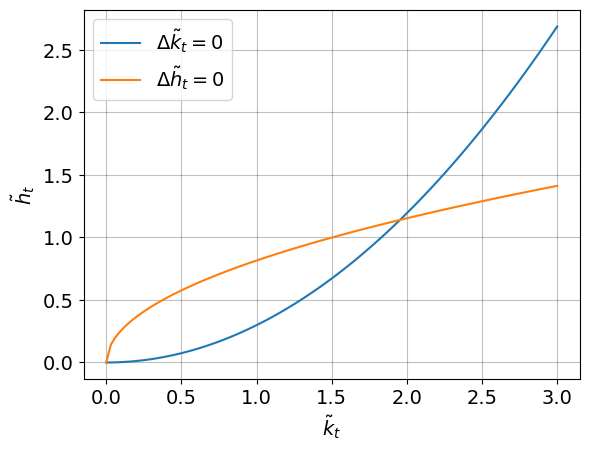

In [13]:
# c. plot results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$');
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$',)

ax.legend(loc='upper left');

The lambdified nullclines seems to behave as hypotesized previously <br>
We check the robusticity of our resulst, with different values of n. We expect that an increase in population growth rate, would decrease the steady state value of k-, and h-tilde.

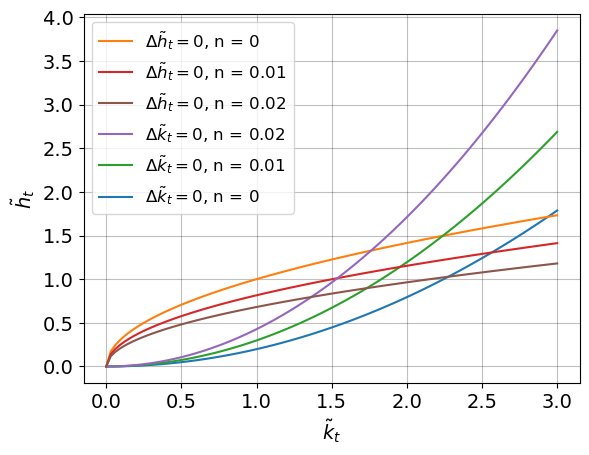

In [14]:
# plot nullclines for different values of n
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# predefine latex-labels 
label_k = r'$ \Delta \tilde{k}_t = 0$'
label_h = r'$ \Delta \tilde{h}_t = 0$'

n_lst=[0, 0.01, 0.02]
for n_val in n_lst:
    null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
    null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)
    ax.plot(k_tilde_vec,null_k_val, label = f'{label_k}, n = {n_val}')
    ax.plot(k_tilde_vec,null_h_val, label = f'{label_h}, n = {n_val}')

# set axis
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$',)

# customize legend 
# i. specify order 
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,3,5,4,2,0] # 0 is the first label in default legend.

# ii. pass handle & labels lists along with order
ax.legend([handles[i] for i in order], [labels[i] for i in order],fontsize="12");

In [43]:
# show convergence from simulation
 
# a. do simulation 
# i. initialize model
def plot_convergence(H_init, K_init):
    
    felix = Solow()
    par = felix.par 
    par.simT = 1000
    # ii. change initial values (outside steady state)
   
    par.A_init = 1
    par.K_init = K_init
    par.H_init = H_init
    par.L_init = 1
    par.Y_init = 1

    # iii. extract simulation & unpack 
    sim_out = felix.find_steady_state() 
    k_t = sim_out.k_tilde
    h_t = sim_out.h_tilde

    # b. insert parameter values from simulation in nullclines  
    # i. define values 
    alpha_val = par.alpha
    delta_val = par.delta
    g_val = par.g
    n_val = par.n
    phi_val = par.phi
    sK_val = sim_out.sK
    sH_val = sim_out.sH

    # ii. find range of k_tilde
    k_tilde_vec = np.linspace(1e-10, max(k_t)+1, 100)

    # ii. insert in lamdified nullclines
    null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
    null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)

        # c. plot results
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
    ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$')
    ax.plot(k_t, h_t, label='simulation', linestyle = "dotted", linewidth = 2)
    ax.set_xlabel(r'$\tilde{k}_t$',)
    ax.set_ylabel(r'$\tilde{h}_t$',)

    ax.legend(loc='upper left');
    
def convergence_interactive():
    out=widgets.interact(plot_convergence, H_init = widgets.SelectionSlider(options=np.linspace(0,5,40), value=5),
                         K_init = widgets.SelectionSlider(options=np.linspace(0,5,40), value=5))
    return display(out)

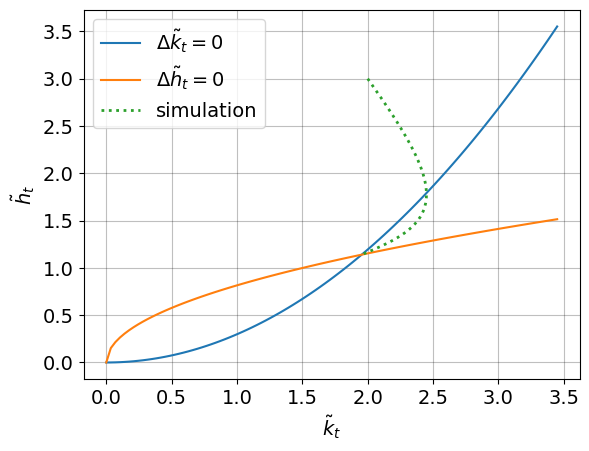

interactive(children=(SelectionSlider(description='H_init', index=39, options=(0.0, 0.1282051282051282, 0.2564…

<function __main__.plot_convergence(H_init, K_init)>

In [44]:
plot_convergence(3,2)
convergence_interactive()

# c. plot results
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)

# ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
# ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$')
# ax.plot(k_t, h_t, label='simulation', linestyle = "dotted", linewidth = 2)
# ax.set_xlabel(r'$\tilde{k}_t$',)
# ax.set_ylabel(r'$\tilde{h}_t$',)

# ax.legend(loc='upper left');